In [2]:
# Notes: For Emissions: "" and -- means missing
# For Energy_Use, "" is missing, For Energy_consumption -- means missing
# For Fossil_fuel_Energy both 0 and "" mean missing, can actually omit this and use renewable_energy instead (too much missing data)
#for GDP and Population -- means missing
# For Renewable_energy_cons "" means missing
# for Rents "" missing
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import missingno as mno
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split


In [3]:
# Load all data and keep only those whose ISO matches all the datasets
countries = pd.read_excel("./countries.xlsx")

def getData(file):
    data = pd.read_csv(file, skiprows=1)
    
    data["Country"]=data["Country"].apply(lambda x: x.strip()) #strip trailing spaces
    data = data[data["Code"].isin(countries["Code"])] # check to see if it is in list
    data.reset_index(drop=True,inplace=True)
    
    return data

In [6]:
#Process all files and add them to a list of dataframes for easy manipulation

df_list = []
df_names = []
for filename in os.listdir("data_processed/"):
    #print(filename)
    path = "data_processed/" + filename
    df_list.append(getData(path))
    df_names.append(filename)

for i in range(15):
    
    print( 'Missing values:', clean_df(df_list[i]).isnull().sum().sum(), '\t File name:', df_names[i])


#mno.matrix(df_list[8], figsize = (10, 3))

Missing values: 88 	 File name: Emissions_Coal.csv
Missing values: 0 	 File name: Emissions_GHG_(fromCAIT).csv
Missing values: 134 	 File name: Emissions_Natural_Gas.csv
Missing values: 218 	 File name: Emissions_Petroleum_other.csv
Missing values: 236 	 File name: Emissions_Total.csv
Missing values: 296 	 File name: Energy_Consumption_per_Capita.csv
Missing values: 296 	 File name: Energy_consumption_per_GDP.csv
Missing values: 1097 	 File name: Energy_use(kg-of-oil-equivalent-per-capita).csv
Missing values: 1134 	 File name: Fossil_fuel_energy_consumption(%_of_total).csv
Missing values: 99 	 File name: GDP.csv
Missing values: 89 	 File name: Population.csv
Missing values: 36 	 File name: Renewable_energy_consumption(%_of_total_final_energy_consumption).csv
Missing values: 140 	 File name: Rents_Coal.csv
Missing values: 120 	 File name: Rents_NaturalGas.csv
Missing values: 112 	 File name: Rents_Oil.csv


In [5]:
def clean_df(temp):
    if 'Code' in temp.columns:
        temp = temp.drop(columns=['Country','Code'])
    
    temp = temp.replace('NaN', np.NaN)
    temp = temp.replace('NA', np.NaN)
    temp = temp.replace('', np.NaN)
    temp = temp.replace('--', np.NaN)
    
    temp = temp.transpose()
    return temp.astype(float)


### KNN imputation

In [85]:
def KNNimpute(dataframe):
    temp = clean_df(dataframe).transpose()

    #Scale data
    scaler = MinMaxScaler()
    temp = scaler.fit_transform(temp)
    temp = temp.transpose()
    #impute
    imputer = KNNImputer(n_neighbors = 3)
    temp = pd.DataFrame(imputer.fit_transform(temp))
    
    #transpose and scale back, and add columns names and index back
    temp = temp.transpose()
    
    temp = pd.DataFrame(scaler.inverse_transform(temp))
    temp.insert(0,'c1',dataframe.Country)
    temp.insert(1,'c2',dataframe.Code)
    
    temp.columns = dataframe.columns
    return temp

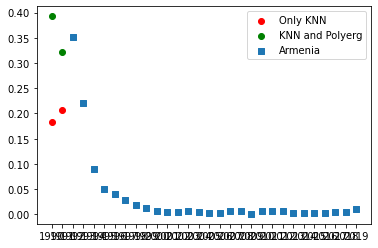

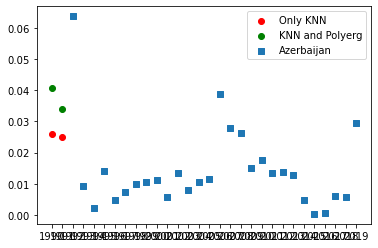

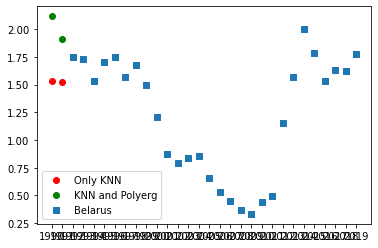

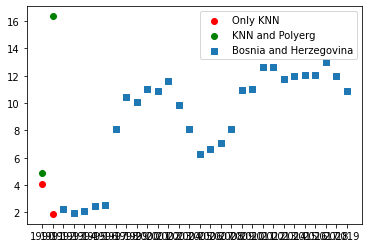

In [106]:
df2 = clean_df(df_list[0]).transpose()
df3 = clean_df(KNNimpute(df_list[0])).transpose()
df4 = clean_df(KNN_and_PolyReg(df_list[0])).transpose()

for i in [5,8,12,18]:
    
    plt.scatter(np.array(df3.iloc[i].index), np.array(df3.iloc[i].values), label = 'Only KNN', color = 'red')
    plt.scatter(np.array(df4.iloc[i].index), np.array(df4.iloc[i].values), label = 'KNN and Polyerg', color = 'green')
    plt.scatter(np.array(df2.iloc[i].index), np.array(df2.iloc[i].values), label = df_list[0].iloc[i,0], marker = 's')
    plt.legend()
    plt.show()

    # review marcro trends, Eastern bloc, Oil, GDP expansions

### Inter/Extra-polation method with added noise

In [ ]:
# https://www.kaggle.com/shashankasubrahmanya/missing-data-imputation-using-regression

In [28]:
#randomly impute missing values by sampling from original 
# This method was not quite effective either
np.random.seed(42)
def random_imputation(df, df_imp, feature):
    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df_imp.loc[df[feature].isnull(), feature] = np.random.choice(observed_values, number_missing, replace = True)
    
    return df_imp[feature]

## Linear Regression imputation and error estimation:

In [271]:
#Simple Linear Regression for imputing missing data
def LinReg_imp(dataframe):
    df = clean_df(dataframe.copy())
    
    for feature in df.columns: # each country is the feature here
        if df[feature].isnull().sum() == 0: # skip if nothing to impute
            continue
        if all(df[feature].isnull()) == 1: # break if all values are NA cannot impute
            continue
        #train on available data, then predict missing data or the data we wanted to impute
        X = df[feature][df[feature].notnull()].index
        X = np.array(X).reshape(-1,1)
        y = df[feature][df[feature].notnull()]
        X = X.astype(float)
        y = y.astype(float)

        model = linear_model.LinearRegression()
        model.fit(X, y)

        y_missing = df[feature][df[feature].isnull()].index
        y_missing = np.array(y_missing).reshape(-1,1)
        y_predicted = model.predict(y_missing)

        #Standard Error of the regression estimates is equal to std() of the errors of each estimates
        stdev = np.std(y)
        df.loc[df[feature].isnull(),feature] = y_predicted + np.random.normal(0,1,  size = y_predicted.shape) * stdev

    temp = df.transpose()
    temp.reset_index(drop=True, inplace=True)
    temp.insert(0,'c1',dataframe.Country)
    temp.insert(1,'c2',dataframe.Code)
    temp.columns = dataframe.columns

    return temp


In [324]:
# Find the Error for this linear Regress
def LinReg_err(dataframe):
    df = clean_df(dataframe.copy())
    total_error = []

    for feature in df.columns:
        if df[feature].isnull().sum() == 0: # skip if nothing to impute
            continue
        if all(df[feature].isnull()) == 1: # break if all values are NA cannot impute
            continue
        #train on available data, then predict missing data
        
        X = df[feature][df[feature].notnull()].index
        X = np.array(X).reshape(-1,1)
        y = df[feature][df[feature].notnull()]
        X = X.astype(float)
        y = y.astype(float)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        model = linear_model.LinearRegression()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        #add std. dev as noise to predictions
        stdev = np.std(y)
        y_pred = np.abs(y_pred + np.random.normal(0,stdev,  size = y_pred.shape) * stdev)
        
        if all(y_test)==0:
            continue
            
        error = np.abs((y_test - y_pred)/y_test)
        
        total_error.append(error.sum())
    return np.sum(total_error),

## Polynomial Regression imputation and error estimation:

In [13]:
# USing n-th degree polynomial regression
def PolyReg_imp(dataframe, poly_degrees):
    df = clean_df(dataframe.copy())

    for feature in df.columns:
        if df[feature].isnull().sum() == 0: # skip if nothing to impute
            continue
        if all(df[feature].isnull()) == 1: # break if all values are NA cannot impute
            continue  
        #train on available data, then predict missing data
        X = df[feature][df[feature].notnull()].index
        X = np.array(X).reshape(-1,1)
        y = df[feature][df[feature].notnull()]

        poly = PolynomialFeatures(degree = poly_degrees)
        X_poly = poly.fit_transform(X)

        poly.fit(X_poly, y)
        lin2 = linear_model.LinearRegression()
        lin2.fit(X_poly, y)


        y_missing = df[feature][df[feature].isnull()].index
        y_missing = np.array(y_missing).reshape(-1,1)

        X_polytest = poly.fit_transform(y_missing)
        y_pred = lin2.predict(X_polytest)
        #Standard Error of the regression estimates is equal to std() of the errors of each estimates
        stdev = np.std(y)
        y_pred = np.abs(y_pred + np.random.normal(0,stdev,  size = y_pred.shape) * stdev)
        df.loc[df[feature].isnull(),feature] = y_pred
    
    temp = df.transpose()
    temp.reset_index(drop=True, inplace=True)
    temp.insert(0,'c1',dataframe.Country)
    temp.insert(1,'c2',dataframe.Code)
    temp.columns = dataframe.columns

    return temp


In [308]:
#np.random.seed(10)
def PolyReg_err(dataframe, poly_degrees):
    df = clean_df(dataframe.copy())
    total_error = []

    for feature in df.columns:
        if df[feature].isnull().sum() == 0: # skip if nothing to impute
            continue
        if all(df[feature].isnull()) == 1: # break if all values are NA cannot impute
            continue
            
        #train on available data, then predict missing data
        X = df[feature][df[feature].notnull()].index
        X = np.array(X).reshape(-1,1)
        y = df[feature][df[feature].notnull()]
        X = X.astype(float)
        y = y.astype(float)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        poly = PolynomialFeatures(degree = poly_degrees)
        X_poly = poly.fit_transform(X_train)

        poly.fit(X_poly, y_train)
        lin2 = linear_model.LinearRegression()
        lin2.fit(X_poly, y_train)

        X_polytest = poly.fit_transform(X_test)
        y_pred = lin2.predict(X_polytest)

        #add std. dev as noise to predictions
        stdev = np.std(y)
        y_pred = np.abs(y_pred + np.random.normal(0,stdev,  size = y_pred.shape) * stdev)
        
        if all(y_test)==0:
            continue
        error = np.abs((y_test - y_pred)/y_test)
        
        total_error.append(error.sum())
    return np.sum( total_error)

# Combining KNN and PolyReg for optimal imputation

In [14]:
# First we comb through the dataframe and find the countries with more than half (15+) years of missing data. For these we use Knn Imputation. For the rest PolyReg 3rd degree will work best
def KNN_and_PolyReg(dataframe):
    dataframe = df_list[0]
    df_knn = clean_df(dataframe).transpose()
    knnimp = df_knn.isna().sum(axis=1) >= 7  # find which countries have more than 8 years of NaN

    #impute for the whole dataframe but keep only those with more than 7 years of NAN
    df = KNNimpute(dataframe)

    #Now just do PolyReg
    df_poly = PolyReg_imp(dataframe, 3)

    df_poly[knnimp] = df[knnimp]
    return df_poly
#data.iloc[99]

## Visualizing the errors from PolyReg and LinReg

In [450]:
df_err = pd.DataFrame(index=df_names, columns = ['LinReg', 'PolyReg2'])

df_err['LinReg'] = [LinReg_err(df_list[i]) for i in range(len(df_list))]
df_err['PolyReg2'] = [PolyReg_err(df_list[i], 2) for i in range(len(df_list))]
df_err['PolyReg3'] = [PolyReg_err(df_list[i], 3) for i in range(len(df_list))]
df_err['PolyReg3_KNN'] = [PolyReg_err(df_list[i], 3) for i in range(len(df_list))]

df_err = df_err.drop(index=['Population.csv','GDP.csv'])



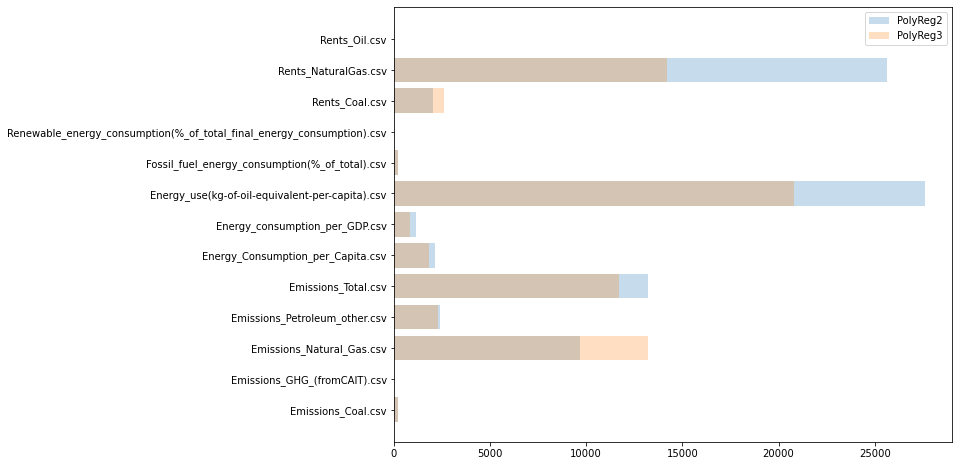

In [451]:
fig = plt.figure(figsize=(10, 8))
[#plt.barh(df_err.index, df_err['LinReg'], alpha = 0.5,align='edge', label='LinReg'), 
plt.barh(df_err.index, df_err['PolyReg2'], alpha = 0.25, label='PolyReg2'), 
plt.barh(df_err.index, df_err['PolyReg3'], alpha = 0.25, label='PolyReg3')]
plt.legend()

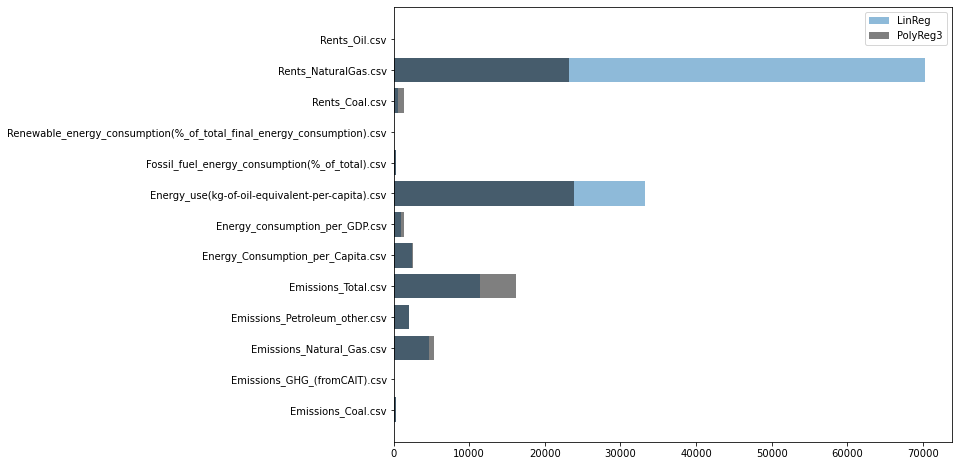

In [387]:
fig = plt.figure(figsize=(10, 8))
[plt.barh(df_err.index, df_err['LinReg'], alpha = 0.5, label='LinReg'), 
#plt.barh(df_err.index, df_err['PolyReg2'], alpha = 0.5, label='PolyReg2'), 
plt.barh(df_err.index, df_err['PolyReg3'], alpha = 0.5, label='PolyReg3', color = 'black')]
plt.title('Mean Absolute Error Comparison')
plt.legend()

### Saving files

In [130]:
# save csv in file
#path = r"C:\Users\fabio\Documents\GitHub\EIB2_ClimateRisk\cleaned data\data_imputed\imputed_knn"

#for i in range(len(df_list)):
    #KNNimpute(df_list[i]).to_csv(path +"/" + df_names[i])

In [459]:
for i in range(len(df_list)):
    PolyReg_imp(df_list[i],3).to_csv(df_names[i])

In [306]:
for i in range(len(df_list)):
    KNNimpute(df_list[i]).to_csv(df_names[i])

### Missing data profile

<BarContainer object of 15 artists>

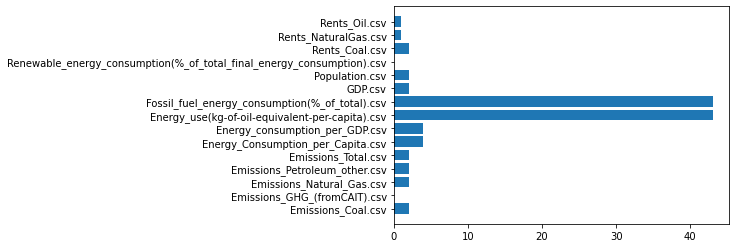

In [445]:
df_missing_ct = pd.DataFrame(columns=df_names, index = df.columns)

for i in range(len(df_list)):
    count = 0
    df = clean_df(df_list[i])
    for j in df.columns:
        if df[j].isnull().sum() >14:
            #print('in df',df_names[i] ,'A country has: ',df[j].isnull().sum(), 'missing values')
            count += 1
    df_missing_ct[df_names[i]] = count
df_missing_ct
plt.barh(df_missing_ct.columns, df_missing_ct.max())

<ipython-input-452-4fc91b67ed08>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


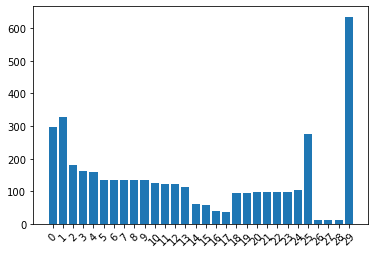

In [452]:
df_missing = pd.DataFrame(columns=df_names)
for i in range(len(df_list)):
    df = clean_df(df_list[i]).transpose()
    for j in df.columns:
        if df[j].isnull().sum() >3:
                #print('in df',df_names[i] ,'in year',j ,' has: ',df[j].isnull().sum(), 'missing values')
                df_missing[df_names[i]] = df.isnull().sum()

df_missing.transpose().sum().shape,df_missing.transpose().columns
plt.bar(df_missing.transpose().columns, df_missing.transpose().sum())
ax = plt.gca()
ax.set_xticklabels(ax.get_xticks(), rotation = 45)
plt.show()

In [33]:

df = pd.DataFrame([[1,2,3],[100,300,500],[10000, 12000, 14000]])
scaler = MinMaxScaler()
df2 = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
df, df2

(       0      1      2
 0      1      2      3
 1    100    300    500
 2  10000  12000  14000,
           0         1         2
 0  0.000000  0.000000  0.000000
 1  0.009901  0.024837  0.035508
 2  1.000000  1.000000  1.000000)

In [80]:
#df = clean_df(df_list[)])
KNNimpute2(df_list[0]).head(15)

         0         1             2             3         4             5    \
0   0.001526  0.001528  0.000000e+00  0.000000e+00  0.001644  8.961901e-05   
1   0.000862  0.001404  0.000000e+00  0.000000e+00  0.001406  9.990706e-05   
2   0.000235  0.001259  0.000000e+00  0.000000e+00  0.001362  1.645958e-04   
3   0.000146  0.000929  0.000000e+00  0.000000e+00  0.001176  9.706332e-05   
4   0.000112  0.000884  1.262505e-06  1.262505e-06  0.001491  3.806203e-05   
5   0.000078  0.000489  0.000000e+00  0.000000e+00  0.001247  1.943350e-05   
6   0.000061  0.000533  1.887085e-06  1.887085e-06  0.001121  1.666500e-05   
7   0.000046  0.000600  0.000000e+00  0.000000e+00  0.001135  1.142654e-05   
8   0.000029  0.000668  0.000000e+00  0.000000e+00  0.001140  7.197869e-06   
9   0.000033  0.000643  0.000000e+00  0.000000e+00  0.001146  4.846328e-06   
10  0.000038  0.000589  4.959498e-08  4.959498e-08  0.000966  2.226818e-06   
11  0.000042  0.000576  0.000000e+00  0.000000e+00  0.000747  1.

,Country,Code,1990,1991,1992,1993,1994,1995,1996,1997,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Albania,ALB,3.130703,1.779817,0.502372,0.332177,0.269835,0.205073,0.161310,0.119023,...,0.329973,0.309336,0.277316,0.246716,0.311598,0.264177,0.205667,0.204719,0.204280,0.234532
1,Algeria,DZA,3.136276,2.898887,2.687475,2.110768,2.150592,1.284432,1.443130,1.537015,...,1.099877,1.407936,1.388799,0.982267,0.833787,0.513685,0.396965,0.410189,0.232647,0.352335
2,Angola,AGO,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Antigua and Barbuda,ATG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Argentina,ARG,3.373197,2.903367,2.906775,2.671719,3.631131,3.278262,3.042341,2.907947,...,3.664644,3.937608,4.320512,4.357923,4.120342,3.856025,3.725291,3.656726,3.053126,1.974290
5,Armenia,ARM,0.183903,0.206327,0.351333,0.220518,0.089702,0.051080,0.040175,0.029270,...,0.005791,0.007508,0.006603,0.003152,0.002484,0.002798,0.002849,0.003707,0.004417,0.011523
6,Australia,AUS,155.822075,158.441840,162.299485,157.161279,157.663172,164.275304,175.733781,180.658842,...,193.453158,184.804494,180.995687,168.465633,160.055324,167.850923,166.152335,160.700259,146.703499,141.675568
7,Austria,AUT,14.127443,15.232404,10.807675,9.358016,9.760491,11.893954,12.516650,12.795775,...,12.262878,12.373503,11.797346,12.090293,11.263249,12.029014,11.297731,11.916427,10.410354,11.069428
8,Azerbaijan,AZE,0.025903,0.024936,0.063694,0.009436,0.002359,0.014154,0.004718,0.007304,...,0.017598,0.013336,0.013880,0.012824,0.004828,0.000342,0.000733,0.006178,0.005768,0.029498
9,Bahrain,BHR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
